In [7]:
# Library
import pandas as pd
import numpy as np 
import os 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import xgboost as xgb 
import seaborn as sns
import plotly.express as px 
import ipywidgets as widgets
import itertools
from IPython.display import display, HTML, clear_output
from lifelines import KaplanMeierFitter, CoxPHFitter 
from itertools import combinations, product 
from interpret import show 
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree 
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV 
from sklearn.preprocessing import StandardScaler 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style = 'whitegrid')

In [8]:
# Read Data
customer_data  = pd.read_csv("customer_info.csv")
engagement_data= pd.read_csv("engagement.csv")
labels         = pd.read_csv("labels.csv")
policy_data    = pd.read_csv("policy_data.csv")
transaction    = pd.read_csv("transactions.csv")

# Meger Data
dfs = [customer_data, engagement_data, labels, policy_data]
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='customer_id', how='left')

# Time Format
merged_df['last_login_date']   = pd.to_datetime(merged_df['last_login_date'], errors='coerce')
merged_df['policy_start_date'] = pd.to_datetime(merged_df['policy_start_date'], errors='coerce')
merged_df['churn_date']        = pd.to_datetime(merged_df['churn_date'], errors='coerce')

# Create Columns
merged_df['days_between_policy_last_login'] = (merged_df['last_login_date'] - merged_df['policy_start_date']).dt.days
merged_df['days_between_policy_churn']      = (merged_df['churn_date'] - merged_df['policy_start_date']).dt.days

def classify_churn_return(row):
    if pd.isna(row['days_between_policy_churn']):
        return "Not Returning"
    elif row['days_between_policy_last_login'] > row['days_between_policy_churn']:
        return "Possibly Returning"
    else:
        return "Possibly Churn"

merged_df['churn_behavior'] = merged_df.apply(classify_churn_return, axis=1)

# Policy tenure
merged_df['policy_tenure'] = (pd.to_datetime('2024-12-31') - merged_df['policy_start_date']).dt.days

# Transaction Features
transaction['transaction_date'] = pd.to_datetime(transaction['transaction_date'], errors='coerce')
premium_tx = transaction[transaction['transaction_type'] == 'Premium'].copy()

payment_features = premium_tx.groupby('customer_id').agg(
    num_transactions    = ('payment_status', 'count'),
    num_failed_payments = ('payment_status', lambda x: (x != "Success").sum()),
    avg_days_overdue    = ('days_overdue', lambda x: x[x > 0].mean()),
    max_days_overdue    = ('days_overdue', 'max'),
    sum_success_payment = ('amount', lambda x: x[premium_tx.loc[x.index, 'payment_status'] == 'Success'].sum()),
).reset_index().fillna(0)

payment_features['failed_payment_rate']  = payment_features['num_failed_payments'] / payment_features['num_transactions']
payment_features['has_chronic_overdue'] = (
    premium_tx[premium_tx['days_overdue'] > 0]
    .groupby('customer_id').size().ge(3).astype(int)
    .reindex(payment_features['customer_id']).fillna(0).astype(int).values
)

merged_df = pd.merge(merged_df, payment_features, on='customer_id', how='left').fillna(0)

# Engagement Score
def calculate_engagement_score(row):
    score = 0
    if row['login_frequency_30d'] >= 5: score += 2
    elif row['login_frequency_30d'] >= 2: score += 1
    if row['mobile_app_user'] == "Yes": score += 2
    if row['email_opens_6m'] >= .6: score += 2
    elif row['email_opens_6m'] >= .3: score += 1
    if row['customer_service_calls_12m'] >= 3: score -= 2
    elif row['customer_service_calls_12m'] >= 1: score -= 1
    if row['complaints_filed'] >= 2: score -= 2
    return score

merged_df['engagement_score'] = merged_df.apply(calculate_engagement_score, axis=1)

# Convert into excecl
merged_df.to_excel('merged_data.xlsx', sheet_name='All Data', index=False)
merged_df[merged_df['churn_reason'].notna()].to_excel('merged_data.xlsx', sheet_name='Churned Customers', index=False)


In [16]:
# wider DF display in notebook
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

HTML("""
<style>
/* JupyterLab */
div.jp-OutputArea, div.jp-OutputArea-output { max-width: 100% !important; }
/* Classic notebook */
div.output_wrapper, div.output { width: 100% !important; max-width: 100% !important; }
.output_png { width: 100% !important; height: auto !important; }
</style>
""")

# --- Make all matplotlib figures larger globally ---
mpl.rcParams.update({
    "figure.figsize": (16, 6),   # wider + taller default
    "figure.dpi": 160,           # sharper plots
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# Data
df = merged_df.copy() 

# Columns to exclude from segmentation
drop_cols = [
    'churned','churn_date','churn_reason','last_login_date','policy_start_date',
    'customer_id','churn_behavior','transaction_date','transaction_type',
    'amount','payment_status','days_overdue'
]
churn_vars = [c for c in df.columns if c not in drop_cols]

# Single Segment
pattern_dfs = {}
for col in churn_vars:
    try:
        if df[col].dtype in ['object','bool'] or df[col].dtype.name == 'category':
            g = df.groupby(col)['churned'].mean().reset_index()
            g.columns = ['value','churn_rate']
        else:
            binned, bins = pd.qcut(df[col], q=5, retbins=True, duplicates='drop')
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            g = df.groupby(binned, observed=False)['churned'].mean().reset_index()
            g.columns = ['value','churn_rate']
        pattern_dfs[col] = g
    except Exception:
        continue

feat_dd = widgets.Dropdown(
    options=sorted(pattern_dfs.keys()),
    description='Feature:',
    style={'description_width':'initial'},
    layout=widgets.Layout(width='40%')
)

out_tbl = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        height='650px',   # was 450px
        overflow='auto',
        border='1px solid #ddd',
        padding='10px',
        margin='6px 0'
    )
)

display(widgets.HTML("<h4>Single-Segment Churn Patterns</h4>"), feat_dd, out_tbl)

def on_change(change):
    if change['name']=='value' and change['new'] is not None:
        with out_tbl:
            clear_output(wait=True)
            g = pattern_dfs[change['new']].copy()
            g['value'] = g['value'].astype(str)
            display(g)
            plt.figure(figsize=(18, 7))  # bigger per-plot
            plt.bar(g['value'], g['churn_rate'])
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Churn Rate')
            plt.title(f'Churn Rate by {change["new"]}')
            plt.tight_layout()
            plt.show()

feat_dd.observe(on_change, names='value')
if feat_dd.options:
    feat_dd.value = feat_dd.options[0]

# Cross Segment
min_sample = widgets.IntSlider(
    value=500, min=100, max=2000, step=50,
    description='Min samples/segment:', layout=widgets.Layout(width='48%')
)
max_combo = widgets.IntSlider(
    value=3, min=1, max=4, step=1,
    description='Max combo size:', layout=widgets.Layout(width='40%')
)
run_btn = widgets.Button(
    description='Run',
    button_style='primary',
    layout=widgets.Layout(width='10%')
)

cross_out = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        height='750px',   # was 520px
        overflow='auto',
        border='1px solid #ddd',
        padding='10px',
        margin='6px 0'
    )
)
display(widgets.HTML("<h4>Cross-Segment Churn</h4>"), widgets.HBox([min_sample, max_combo, run_btn]), cross_out)

def run_cross_segments(_):
    with cross_out:
        clear_output(wait=True)
        results = []
        for r in range(1, min(max_combo.value, len(churn_vars)) + 1):
            for combo in itertools.combinations(churn_vars, r):
                try:
                    g = (
                        df.groupby(list(combo))
                          .agg(count=('churned','count'), churn_rate=('churned','mean'))
                          .reset_index()
                    )
                    g = g[g['count'] > min_sample.value]
                    if not g.empty:
                        g['variables'] = ', '.join(combo)
                        results.append(g)
                except Exception:
                    continue

        if not results:
            print("No high-churn cross segments found.")
            return

        cross_df = pd.concat(results, ignore_index=True)
        value_cols = [c for c in cross_df.columns if c not in ['count','churn_rate','variables']]
        cross_df['segment_values'] = cross_df.apply(
            lambda row: " | ".join(f"{c}:{row[c]}" for c in value_cols if pd.notna(row[c])),
            axis=1
        )

        display_df = cross_df[['variables','segment_values','count','churn_rate']].copy()
        top_display_df = display_df.sort_values('churn_rate', ascending=False).head(30)

        print(f"Top {len(top_display_df)} High-Churn Cross Segments (min samples = {min_sample.value})")
        display(top_display_df)

        plt.figure(figsize=(18, max(8, 0.5*len(top_display_df))))
        plt.barh(range(len(top_display_df)), top_display_df['churn_rate'])
        plt.yticks(range(len(top_display_df)), top_display_df['segment_values'])
        plt.gca().invert_yaxis()
        plt.xlabel('Churn rate')
        plt.title('Top High-Churn Cross Segments')
        plt.tight_layout()
        plt.show()

run_btn.on_click(run_cross_segments)
run_cross_segments(None)  # auto-run once

# Churn Reason
title_reason = widgets.HTML("<h4>Churn Reason Profile</h4>")
reason_out = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        height='750px',   # was 600px
        overflow='auto',
        border='1px solid #ddd',
        padding='10px',
        margin='6px 0'
    )
)

if 'churn_reason' not in df.columns:
    display(title_reason)
    print("Column 'churn_reason' not found in data.")
else:
    # Cast to string to avoid mixed-type sort errors
    reasons = sorted(df['churn_reason'].dropna().astype(str).unique().tolist())

    reason_dd = widgets.Dropdown(
        options=reasons,
        description='Churn reason:',
        style={'description_width':'initial'},
        layout=widgets.Layout(width='50%')
    )
    display(title_reason, reason_dd, reason_out)

    exclude_cols = {
        'customer_id','churned','churn_date','policy_start_date','last_login_date',
        'transaction_date','transaction_type','amount','payment_status','days_overdue',
        'policy_amount','premium_amount','days_between_policy_churn'
    }

    def render_reason_table(_=None):
        with reason_out:
            clear_output(wait=True)
            sel = reason_dd.value
            if sel is None:
                print("Select a churn reason.")
                return

            # Compare against string-cast column to match dropdown
            cr_str = df['churn_reason'].astype(str)
            reason_df = df[cr_str == sel]
            all_churned_df = df[df['churned'] == 1]

            profile_rows = []
            cand_cols = [c for c in df.columns if c not in exclude_cols]
            for col in cand_cols:
                try:
                    if df[col].dtype in ['object','bool'] or df[col].dtype.name == 'category':
                        vals = df[col].dropna().unique()
                        for v in vals:
                            p1 = (reason_df[col] == v).mean() if len(reason_df) else 0.0
                            p2 = (all_churned_df[col] == v).mean() if len(all_churned_df) else 0.0
                            diff = p1 - p2
                            profile_rows.append({
                                "Feature": f"{col} = {v}",
                                "Reason %": p1,
                                "All churned %": p2,
                                "Difference": diff
                            })
                except Exception:
                    continue

            if not profile_rows:
                print("No categorical features to profile.")
                return

            profile_df = pd.DataFrame(profile_rows).sort_values("Difference", ascending=False)
            show_df = profile_df.copy()
            for c in ["Reason %","All churned %","Difference"]:
                show_df[c] = (show_df[c]*100).round(1).astype(str) + "%"

            print(f"Churn Reason Profile — {sel}")
            display(show_df.head(30))

            topN = 15
            top_plot = profile_df.head(topN)
            plt.figure(figsize=(18, 0.5*len(top_plot)+2))
            plt.barh(range(len(top_plot)), top_plot["Difference"])
            plt.yticks(range(len(top_plot)), top_plot["Feature"])
            plt.gca().invert_yaxis()
            plt.xlabel("Difference vs. all-churned (percentage points)")
            plt.title(f"Top {topN} features tilted toward '{sel}' reason")
            plt.tight_layout()
            plt.show()

    reason_dd.observe(render_reason_table, names='value')
    if reason_dd.options:
        reason_dd.value = reason_dd.options[0]  # trigger initial render

HTML(value='<h4>Single-Segment Churn Patterns</h4>')

Dropdown(description='Feature:', layout=Layout(width='40%'), options=('age', 'avg_days_overdue', 'complaints_f…

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

HTML(value='<h4>Cross-Segment Churn</h4>')

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

HTML(value='<h4>Churn Reason Profile</h4>')

Dropdown(description='Churn reason:', layout=Layout(width='50%'), options=('0', 'Competition', 'Financial', 'L…

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

In [17]:
mod_out = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        height='650px',
        overflow='auto',
        border='1px solid #ddd',
        padding='12px',
        margin='8px 0'
    )
)
display(mod_out)

def render_modeling():
    with mod_out:
        clear_output(wait=True)
        df_all = merged_df.copy()

        num_vars = ['age','dependents','login_frequency_30d','email_opens_6m','customer_service_calls_12m',
                    'complaints_filed','policy_amount','premium_amount','riders','days_between_policy_last_login',
                    'engagement_score']
        cat_vars = ['gender','marital_status','income_bracket','employment_status','education_level',
                    'mobile_app_user','policy_type','premium_frequency','payment_method','churn_behavior']

        for c in num_vars:
            df_all[c] = pd.to_numeric(df_all[c], errors='coerce')
        for c in cat_vars:
            df_all[c] = df_all[c].astype(str)

        df_all = pd.get_dummies(df_all, columns=cat_vars, drop_first=True)

        drop_due_to_vif = [
            'premium_amount','policy_amount','policy_tenure','max_days_overdue','avg_days_overdue','age',
            'premium_frequency_Monthly','num_transactions','engagement_score','email_opens_6m'
        ]

        X = df_all.drop(
            columns=['churned','customer_id','churn_date','policy_start_date',
                     'churn_reason','last_login_date','days_between_policy_churn'],
            errors='ignore'
        )
        X = X.drop(columns=drop_due_to_vif, errors='ignore')

        leak_cols = [c for c in X.columns if c.startswith('churn_behavior_')]
        X = X.drop(columns=leak_cols, errors='ignore')

        X = X.apply(pd.to_numeric, errors='coerce')
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.select_dtypes(include=[np.number])
        X = X.dropna(axis=0)

        y = df_all.loc[X.index, 'churned'].astype(int)

        # Data Split
        sorted_idx = df_all.loc[X.index].sort_values('policy_start_date').index
        X = X.loc[sorted_idx]
        y = y.loc[sorted_idx]

        n = len(X)
        train_end = int(n*0.6)
        val_end   = int(n*0.8)

        X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
        X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
        X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

        X_train_const = sm.add_constant(X_train, has_constant='add')
        X_val_const   = sm.add_constant(X_val,   has_constant='add')
        X_test_const  = sm.add_constant(X_test,  has_constant='add')

        # 1) Logistic (statsmodels)
        logit = sm.Logit(y_train, X_train_const).fit(disp=False)
        display(HTML("<h4>Logistic Regression Summary</h4>"))
        display(logit.summary())

        y_val_prob  = logit.predict(X_val_const)
        y_test_prob = logit.predict(X_test_const)
        print("Logit AUC (val):", roc_auc_score(y_val, y_val_prob))

        # 2) Random Forest
        rf = RandomForestClassifier(
            n_estimators=1000, max_depth=10, class_weight='balanced', n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_val_rf = rf.predict_proba(X_val)[:,1]
        y_test_rf = rf.predict_proba(X_test)[:,1]
        print("RF AUC (val):", roc_auc_score(y_val, y_val_rf))

        # 3) XGBoost
        xgb_clf = xgb.XGBClassifier(
            n_estimators=1000, max_depth=5, learning_rate=0.01,
            eval_metric='logloss', tree_method='hist'
        )
        xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_val_xgb = xgb_clf.predict_proba(X_val)[:,1]
        y_test_xgb = xgb_clf.predict_proba(X_test)[:,1]
        print("XGB AUC (val):", roc_auc_score(y_val, y_val_xgb))

        # 4) Decision Tree
        dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
        dt.fit(X_train, y_train)
        y_val_dt = dt.predict_proba(X_val)[:,1]
        y_test_dt = dt.predict_proba(X_test)[:,1]
        print("DT AUC (val):", roc_auc_score(y_val, y_val_dt))

        # 5) EBM
        ebm = ExplainableBoostingClassifier(interactions=4)
        ebm.fit(X_train, y_train)
        y_val_ebm = ebm.predict_proba(X_val)[:,1]
        y_test_ebm = ebm.predict_proba(X_test)[:,1]
        print("EBM AUC (val):", roc_auc_score(y_val, y_val_ebm))

        proba_dict = {
            "Logistic":      y_test_prob,
            "RandomForest":  y_test_rf,
            "XGBoost":       y_test_xgb,
            "DecisionTree":  y_test_dt,
            "EBM":           y_test_ebm
        }

        dd = widgets.Dropdown(
            options=list(proba_dict.keys()),
            description='Models:',
            layout=widgets.Layout(width='40%')
        )
        th = widgets.FloatSlider(
            value=0.34, min=0.0, max=1.0, step=0.01,
            description='Threshold:',
            layout=widgets.Layout(width='50%')
        )
        out = widgets.Output()
        display(widgets.HBox([dd, th]), out)

        def update(*_):
            with out:
                clear_output(wait=True)
                name = dd.value
                yp = proba_dict[name]
                thr = th.value
                yhat = (yp >= thr).astype(int)
                auc = roc_auc_score(y_test, yp)
                acc = accuracy_score(y_test, yhat)
                cm  = confusion_matrix(y_test, yhat)
                print(f"[{name}]  AUC={auc:.4f}  ACC={acc:.4f}  ChurnRate={yhat.mean():.2%}")
                print("Confusion Matrix:\n", cm)
                print("\nClassification Report:\n", classification_report(y_test, yhat, digits=4))

                fpr, tpr, _ = roc_curve(y_test, yp)
                plt.figure(figsize=(5,4))
                plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
                plt.plot([0,1],[0,1],'k--'); plt.legend()
                plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {name}")
                plt.tight_layout(); plt.show()

        dd.observe(update, names='value')
        th.observe(update, names='value')
        update()

        # Retention
        sim_cols = X_test.columns
        sim = X_test.copy()

        s1 = widgets.IntSlider(value=0, min=-10, max=10, description='customer_service_calls_12m Δ')
        s2 = widgets.IntSlider(value=0, min=-10, max=10, description='login_frequency_30d Δ')
        s3 = widgets.IntSlider(value=0, min=-5,  max=5,  description='complaints_filed Δ')
        s4 = widgets.IntSlider(value=0, min=-1,  max=1,  description='has_chronic_overdue Δ')

        model_pick = widgets.Dropdown(options=list(proba_dict.keys()), description='Simulation model:')
        out_sim = widgets.Output()
        display(widgets.VBox([model_pick, s1, s2, s3, s4]), out_sim)

        def run_sim(*_):
            with out_sim:
                clear_output(wait=True)
                sim_df = sim.copy()
                if 'customer_service_calls_12m' in sim_cols:
                    sim_df['customer_service_calls_12m'] = (sim_df['customer_service_calls_12m'] + s1.value).clip(lower=0)
                if 'login_frequency_30d' in sim_cols:
                    sim_df['login_frequency_30d'] = (sim_df['login_frequency_30d'] + s2.value).clip(lower=0)
                if 'complaints_filed' in sim_cols:
                    sim_df['complaints_filed'] = (sim_df['complaints_filed'] + s3.value).clip(lower=0)
                if 'has_chronic_overdue' in sim_cols:
                    sim_df['has_chronic_overdue'] = (sim_df['has_chronic_overdue'] + s4.value).clip(lower=0)

                name = model_pick.value
                if name == "Logistic":
                    yp = logit.predict(sm.add_constant(sim_df, has_constant='add'))
                elif name == "RandomForest":
                    yp = rf.predict_proba(sim_df)[:,1]
                elif name == "XGBoost":
                    yp = xgb_clf.predict_proba(sim_df)[:,1]
                elif name == "DecisionTree":
                    yp = dt.predict_proba(sim_df)[:,1]
                else:
                    yp = ebm.predict_proba(sim_df)[:,1]

                rate = (yp >= th.value).mean()
                print(f"{name}: Simulated Predicted Churn Rate = {rate:.2%}")

        for w in [model_pick, s1, s2, s3, s4, th]:
            w.observe(run_sim, names='value')
        run_sim()

render_modeling()

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

Monthly Churn Customer Count
  churn_month  churn_count
0  2023-10-01          453
1  2023-11-01          512
2  2023-12-01          522
3  2024-01-01           13


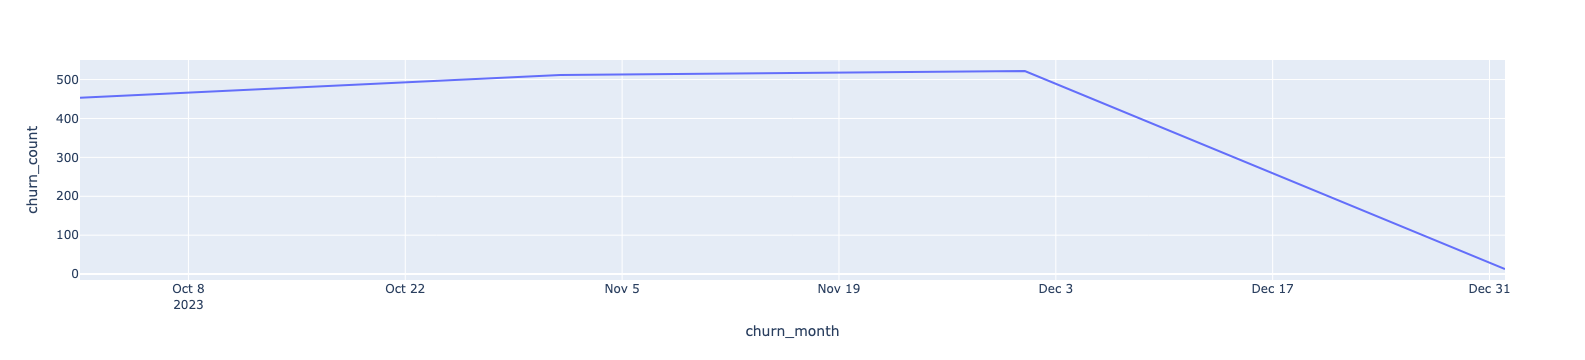

Churn Reason Distribution


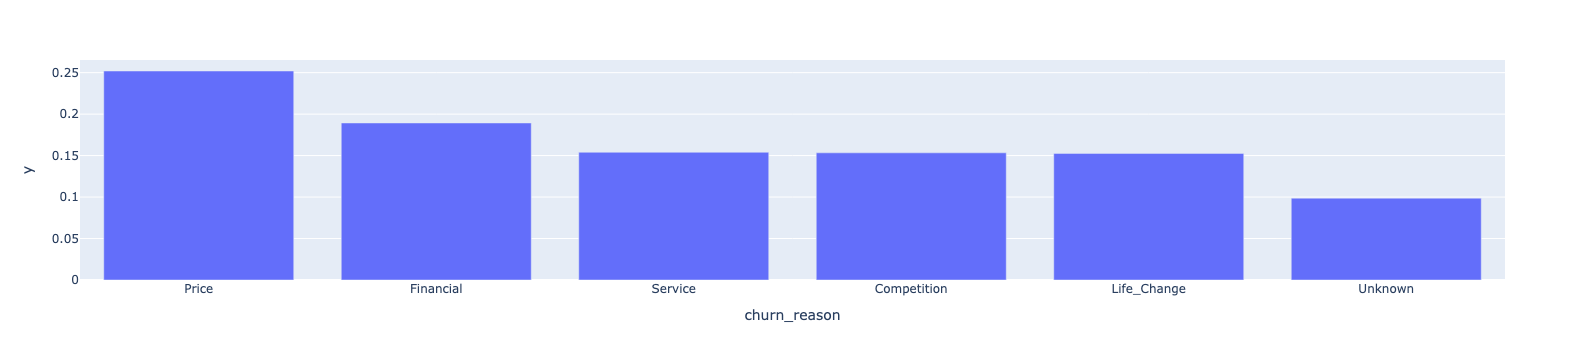

   policy_month  policy_start_count  monthly_churn_count
0    2022-01-01                 445                   69
1    2022-02-01                 434                   72
2    2022-03-01                 479                   81
3    2022-04-01                 495                   79
4    2022-05-01                 532                   81
5    2022-06-01                 481                   73
6    2022-07-01                 488                   79
7    2022-08-01                 436                   68
8    2022-09-01                 424                   64
9    2022-10-01                 472                   68
10   2022-11-01                 497                   72
11   2022-12-01                 452                   65
12   2023-01-01                 521                   77
13   2023-02-01                 437                   65
14   2023-03-01                 488                   75
15   2023-04-01                 461                   61
16   2023-05-01                

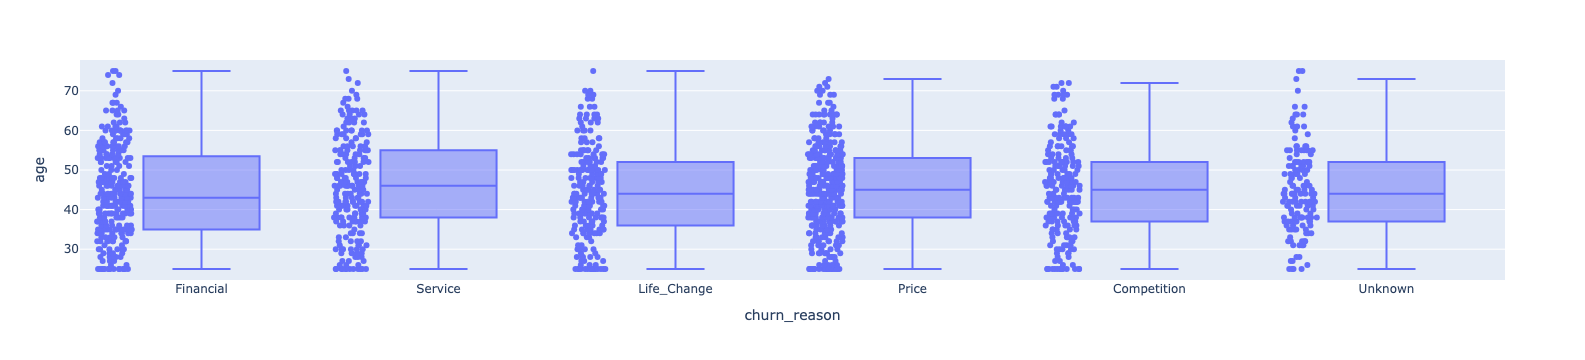

Churn Days Analysis
Linear Regression Results
R-squared: 0.6437523942837184
MSE: 852.8578566191292


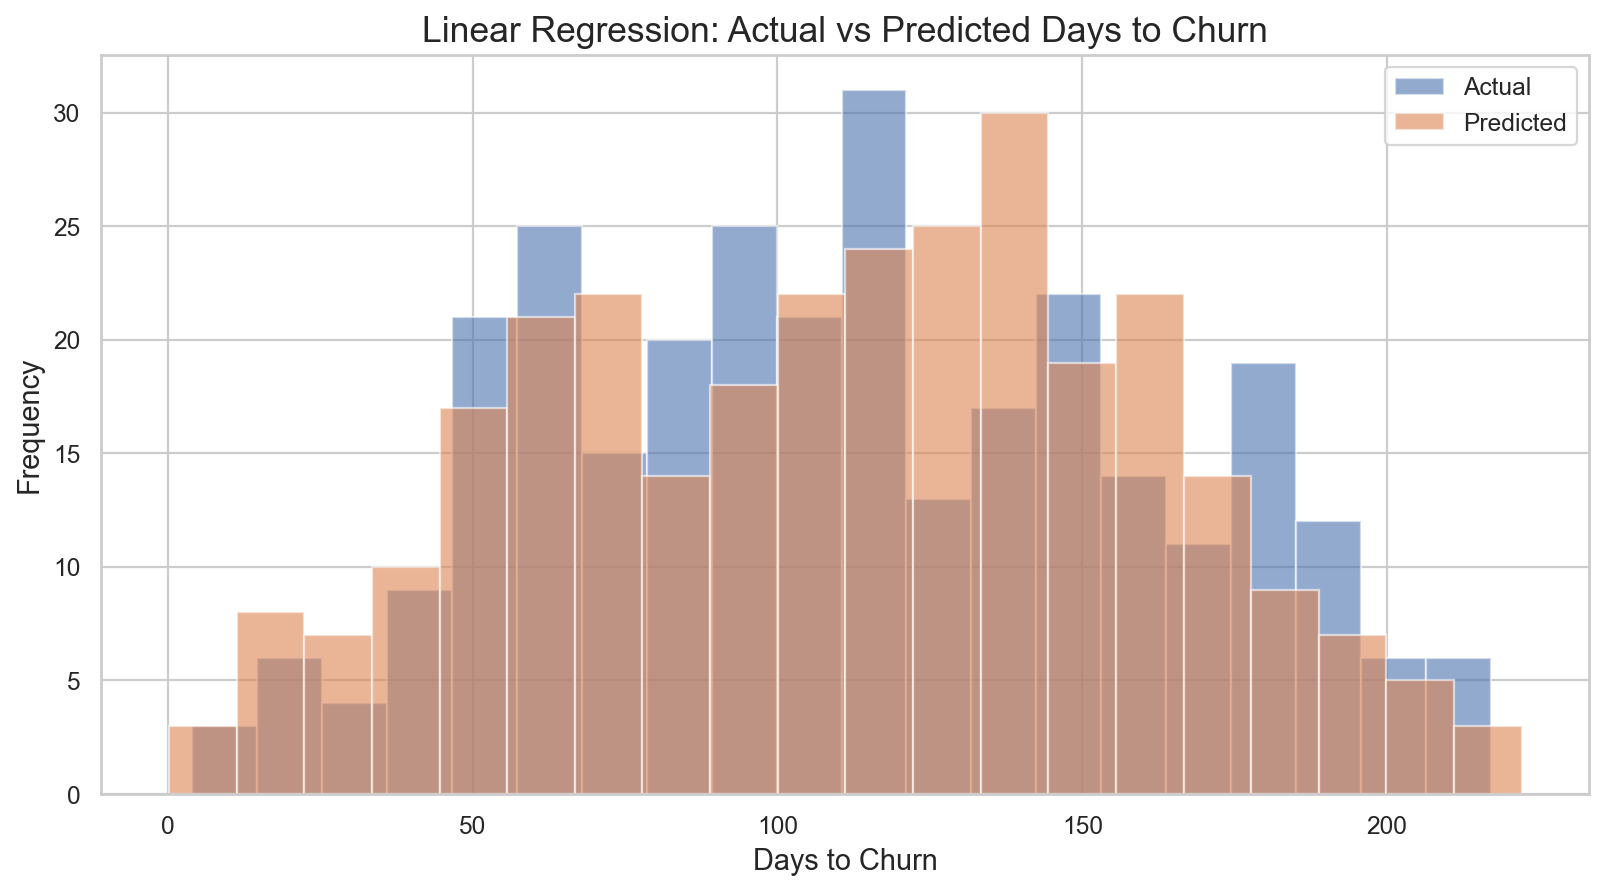

Lasso alpha: 1.1080435585289028
R-squared: 0.7655972290453008
MSE: 561.1609498962389


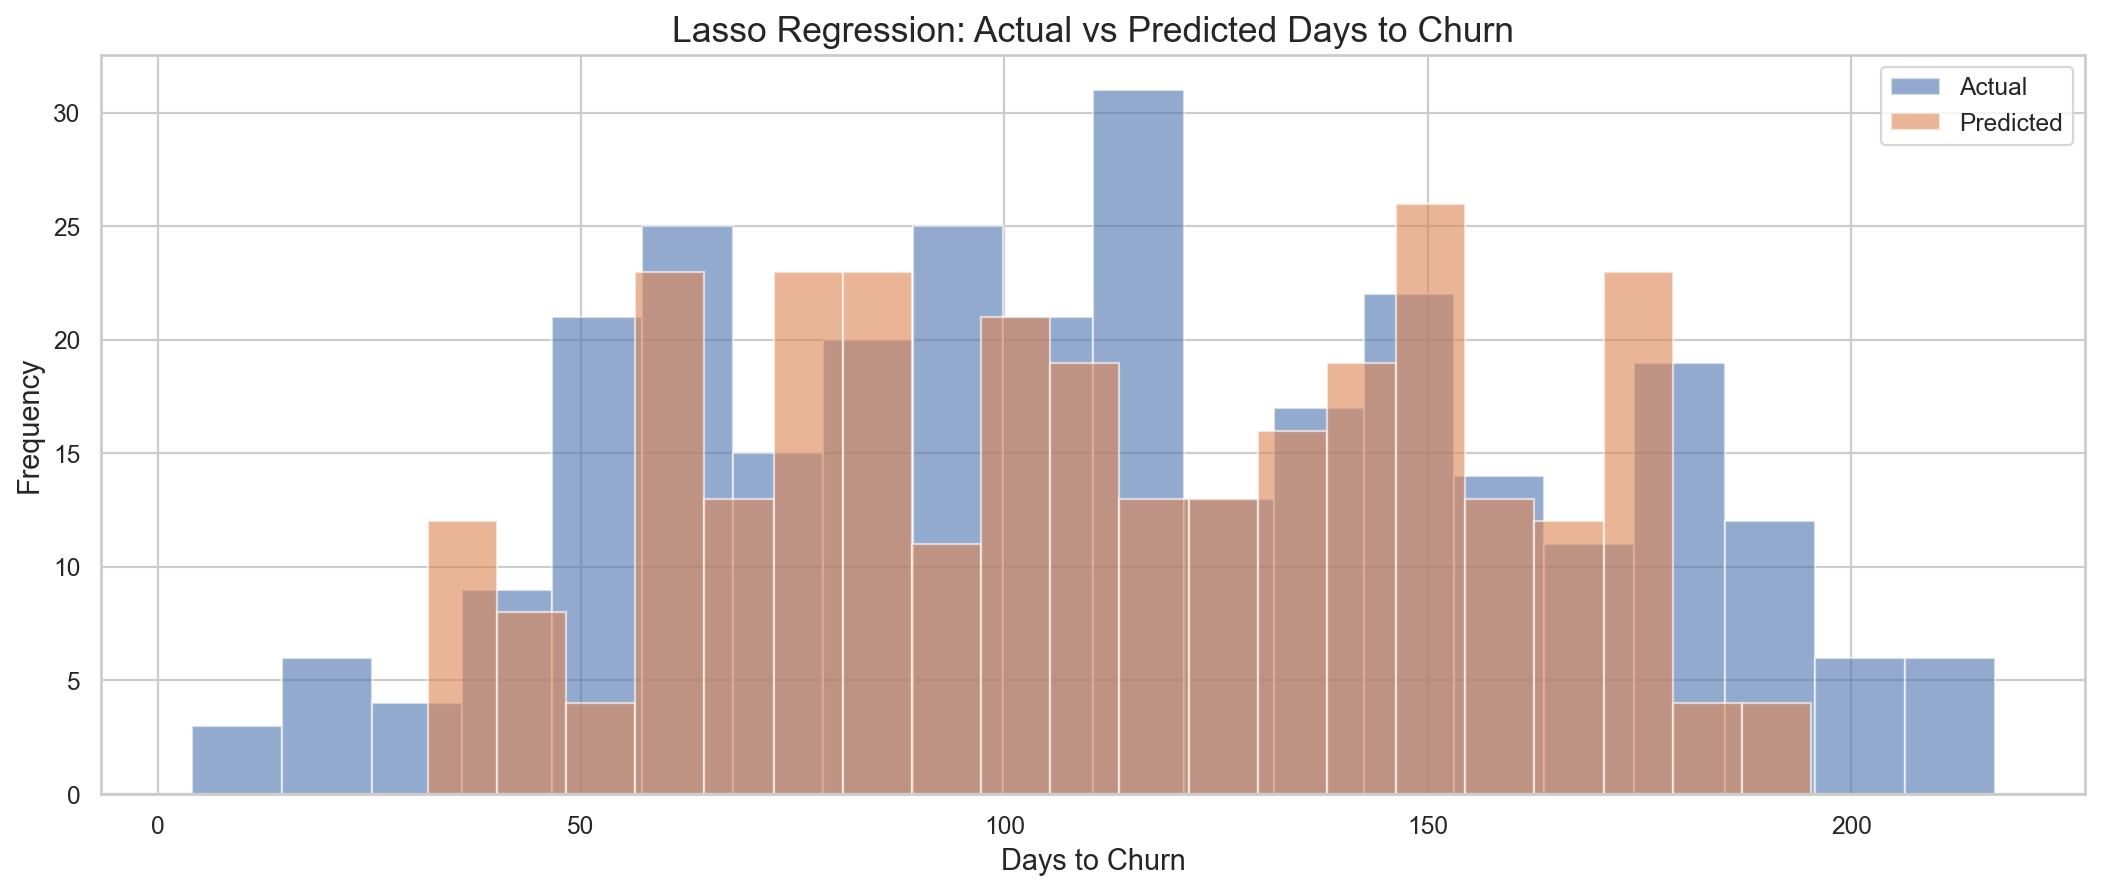

Ridge alpha: 3.5564803062231287
R-squared: 0.6474590100654383
MSE: 843.9842071119214


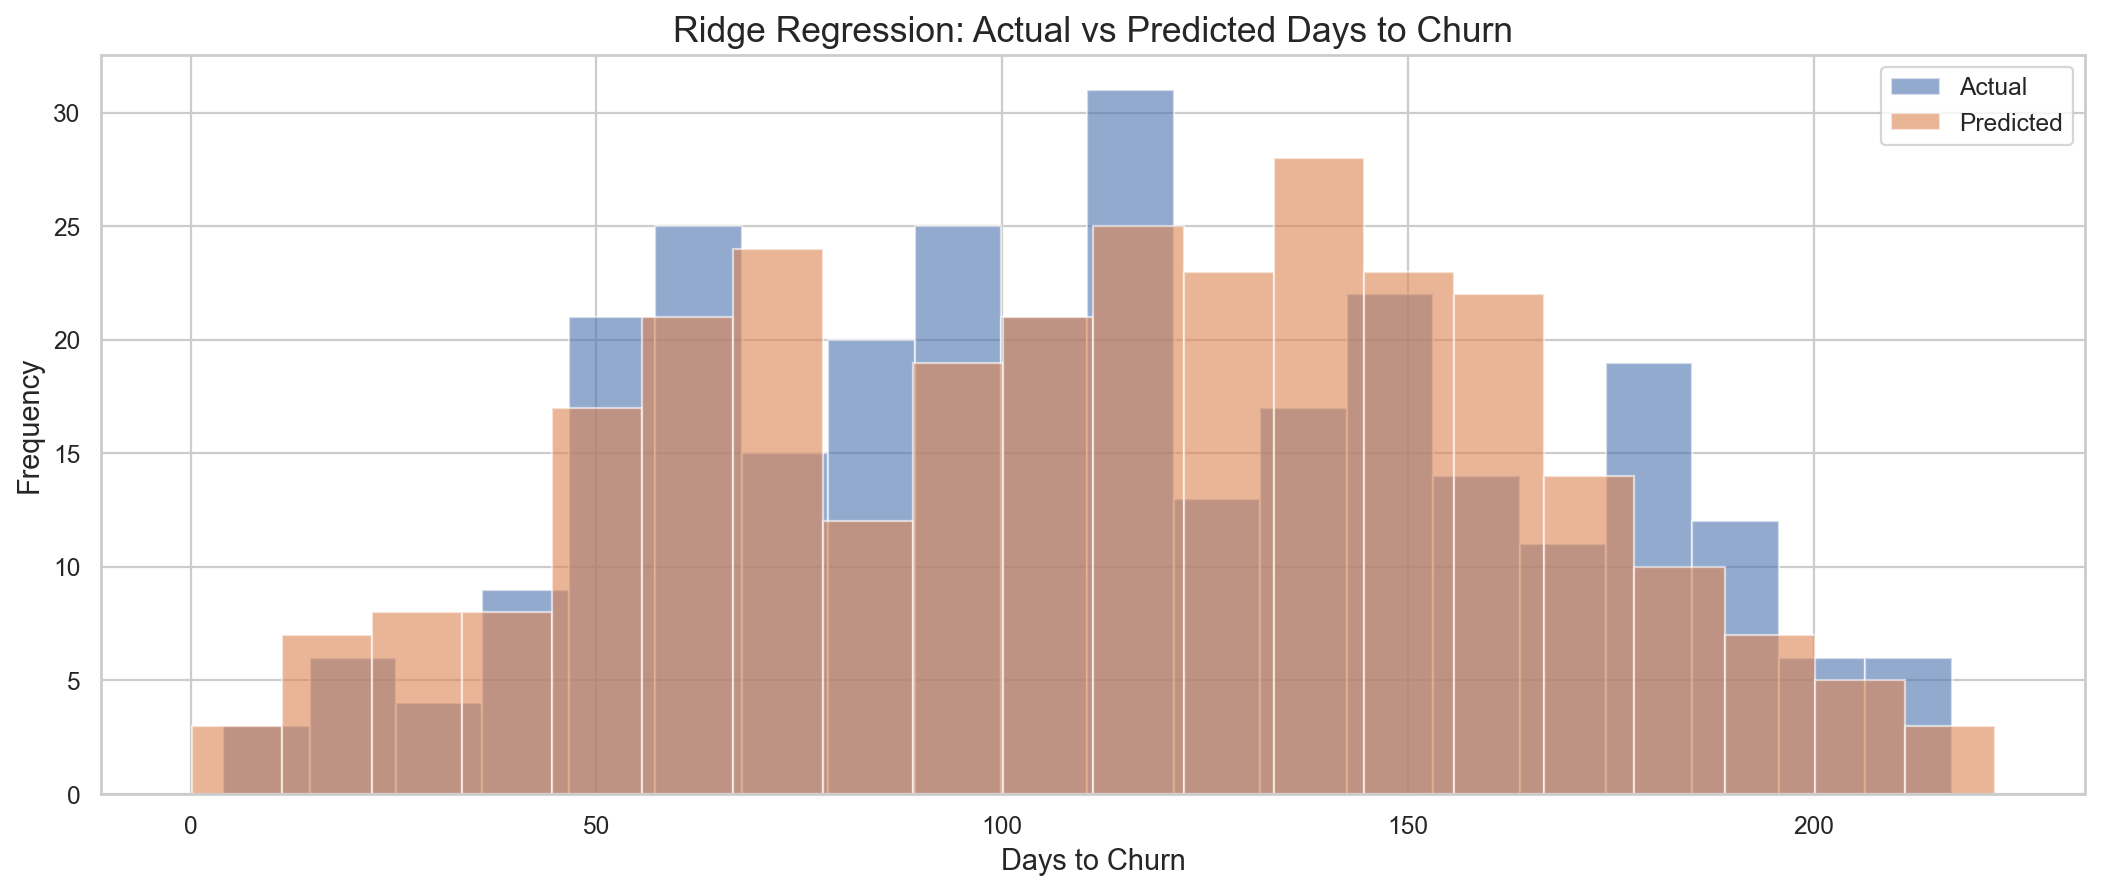

XGB R-squared: -1.2531754970550537
XGB MSE: 5394.109375


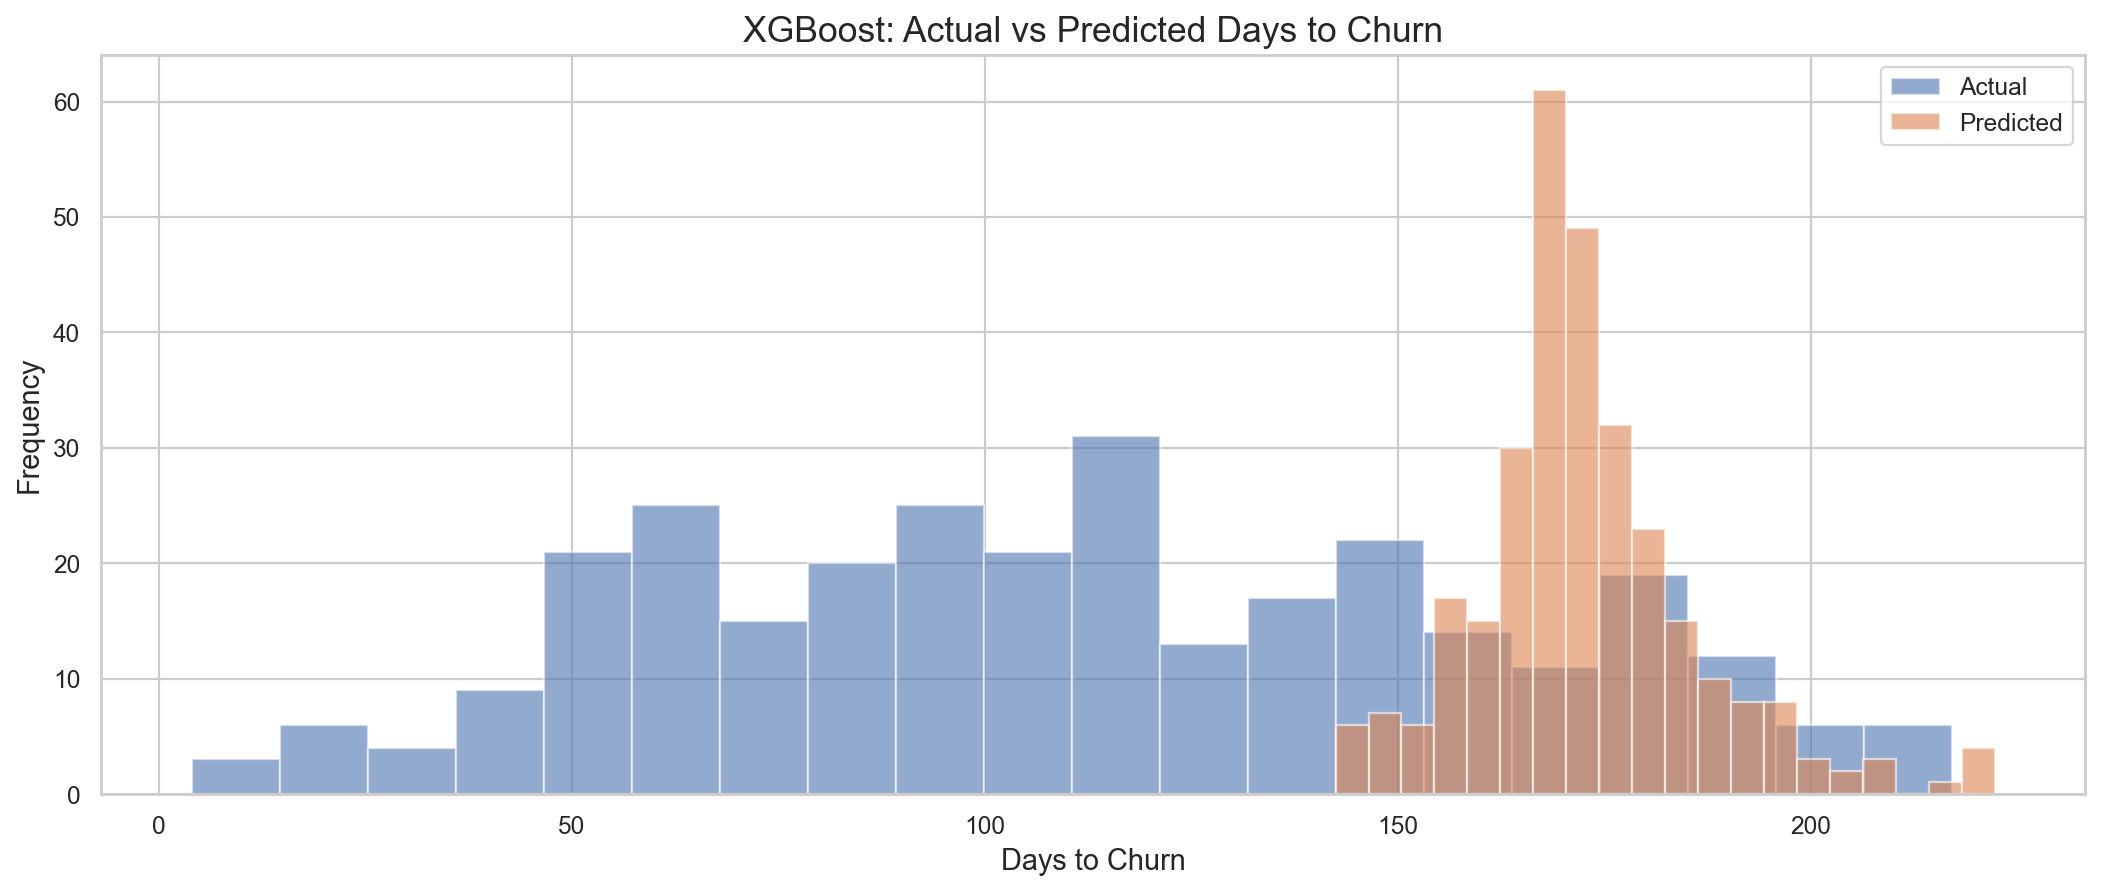

RF R-squared: -6.201399764020096
RF MSE: 17240.173039341167


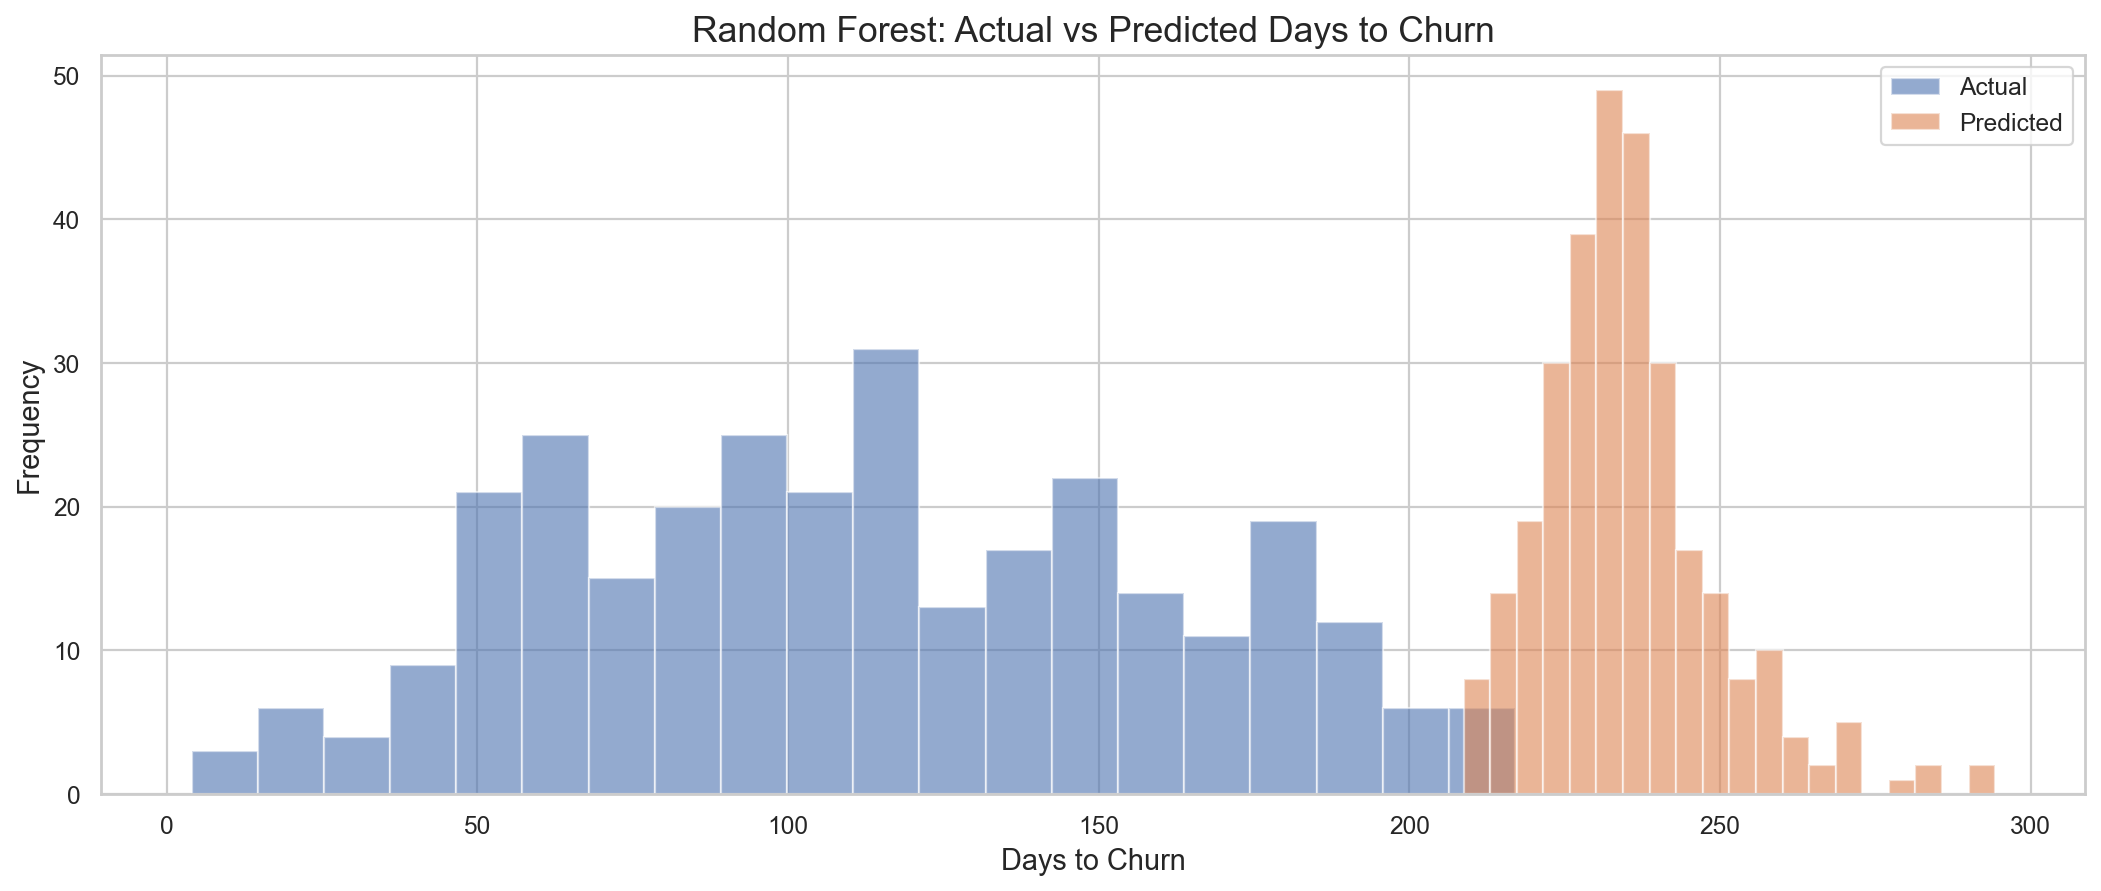

DT R-squared: -1.6784198766048881
DT MSE: 6412.1453686528375


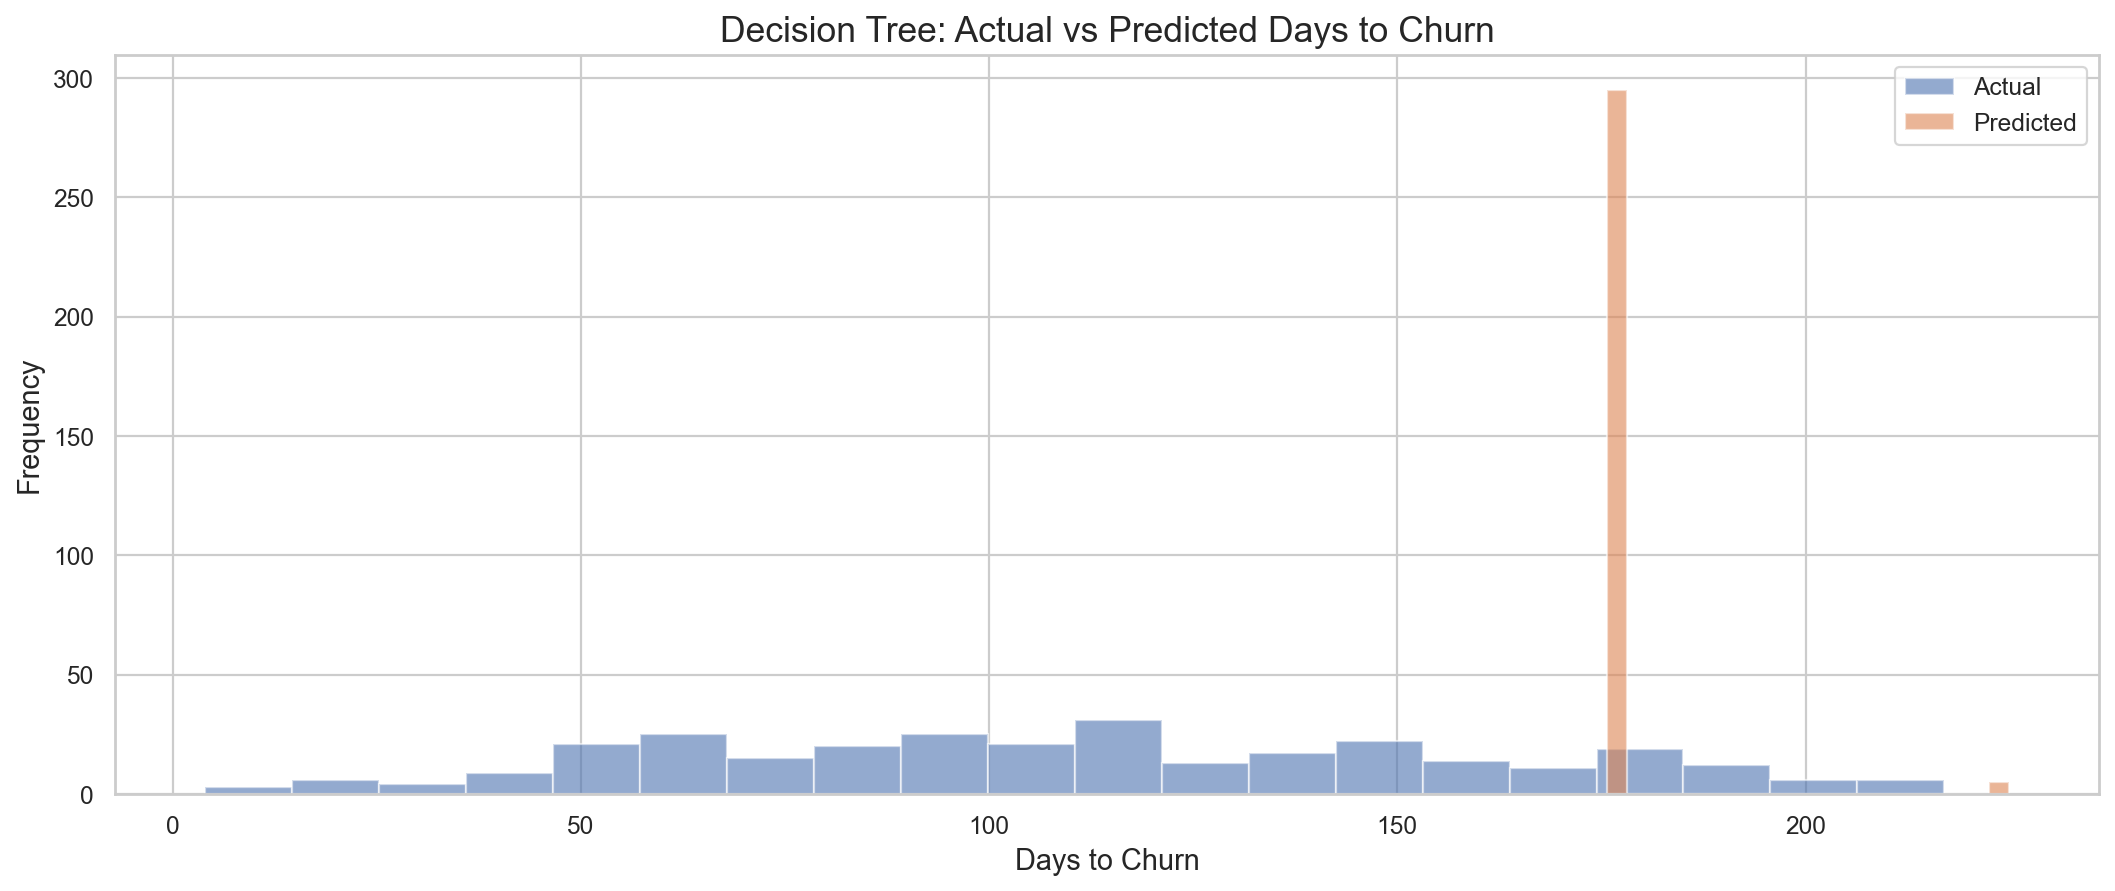

EBM R-squared: 0.42228117586859726
EBM MSE: 1383.060630222541


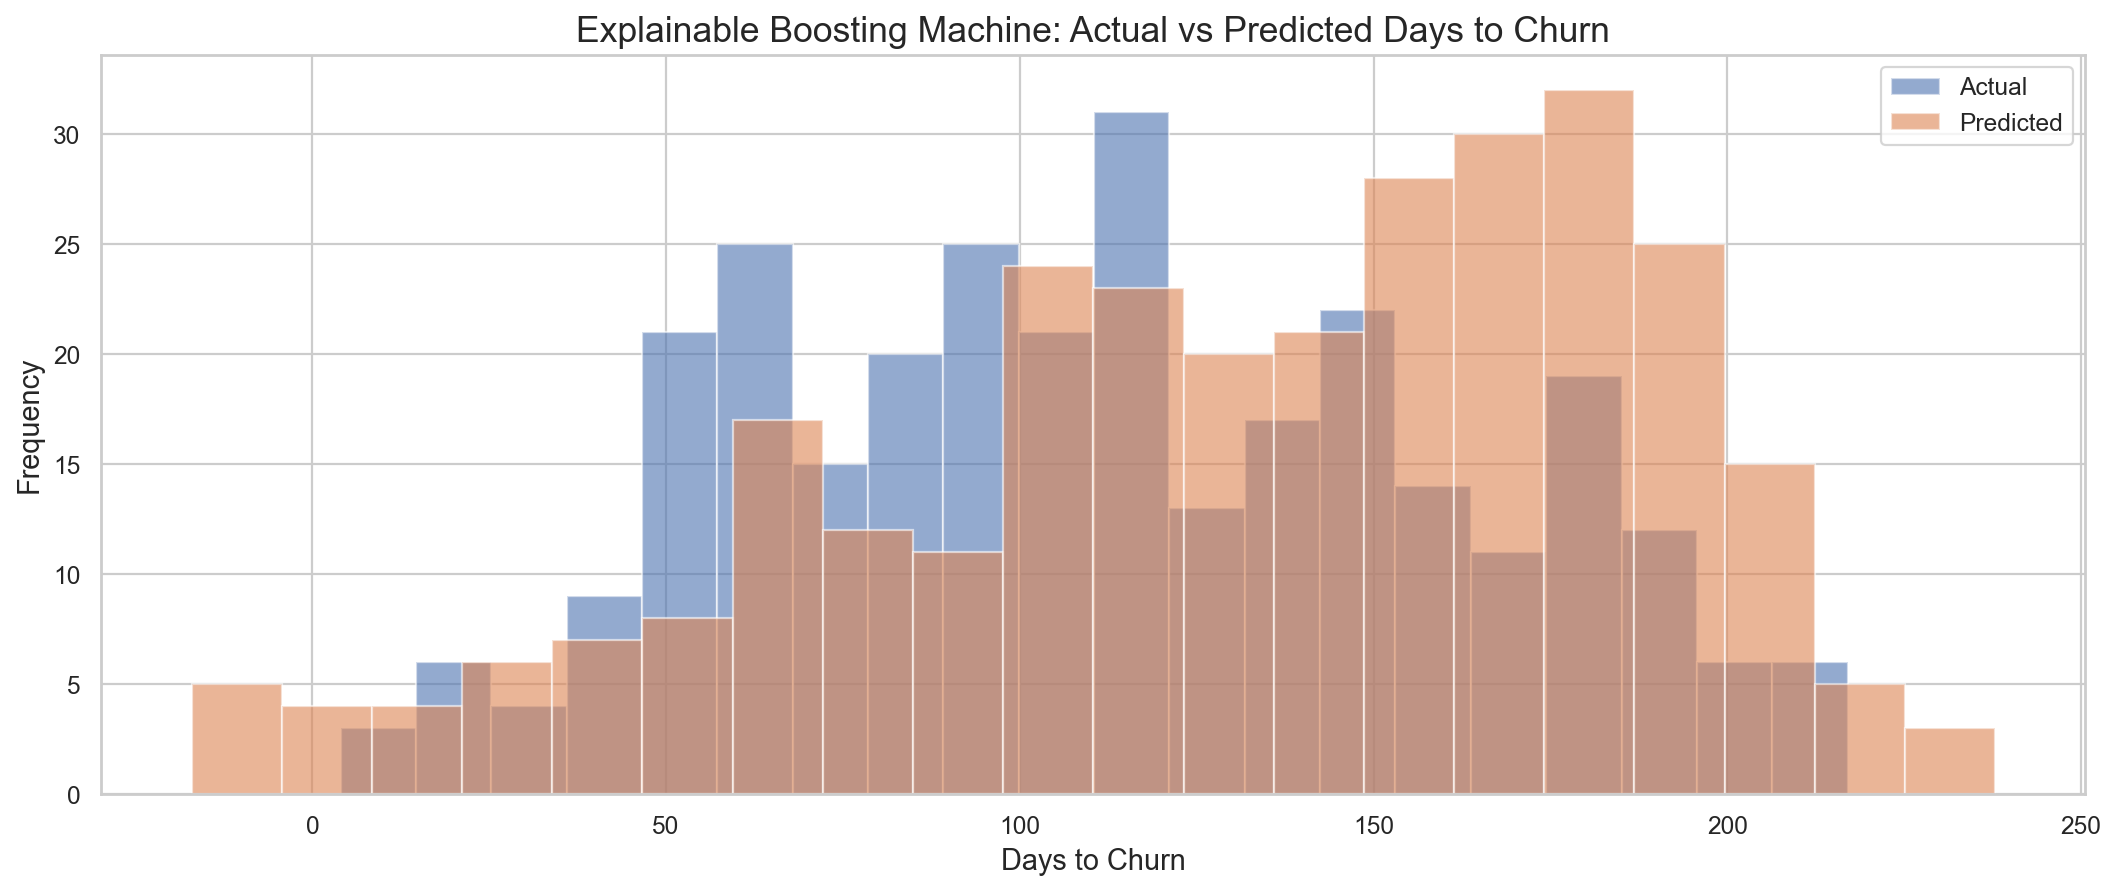

In [18]:
# Read Data
churned_customers = pd.read_excel('merged_data.xlsx', sheet_name='Churned Customers')
merged_df = pd.read_excel('merged_data.xlsx')

# Fix the Time
merged_df['policy_start_date'] = pd.to_datetime(merged_df['policy_start_date'], errors='coerce')

### CLEAN policy_start_date
merged_df = merged_df[merged_df['policy_start_date'].notna()]                    
merged_df = merged_df[merged_df['policy_start_date'].dt.year >= 2000]            

merged_df['policy_month'] = merged_df['policy_start_date'].dt.to_period('M')
monthly_starts_df = merged_df.groupby('policy_month').agg(
    policy_start_count=('customer_id', 'count'),
    monthly_churn_count=('churned', 'sum')
).reset_index()
monthly_starts_df['policy_month'] = monthly_starts_df['policy_month'].dt.to_timestamp()

# Churn_date
churned_customers['churn_date'] = pd.to_datetime(churned_customers['churn_date'], errors='coerce')

### CLEAN churn_date
churned_customers = churned_customers[churned_customers['churn_date'].notna()]   
churned_customers = churned_customers[churned_customers['churn_date'].dt.year >= 2000]  

churned_customers['churn_month'] = churned_customers['churn_date'].dt.to_period('M')
monthly_churn_df = churned_customers.groupby('churn_month').agg(churn_count=('customer_id', 'count')).reset_index()
monthly_churn_df['churn_month'] = monthly_churn_df['churn_month'].dt.to_timestamp()

print("Monthly Churn Customer Count")
print(monthly_churn_df)
px.line(monthly_churn_df, x="churn_month", y="churn_count").show()

churn_reason_counts = churned_customers['churn_reason'].value_counts(normalize=True)
print("Churn Reason Distribution")
px.bar(churn_reason_counts, x=churn_reason_counts.index, y=churn_reason_counts.values).show()

print(monthly_starts_df)

print("Churn Reason VS Key Features")
selected_features = [
    'age', 'gender', 'marital_status', 'dependents', 'income_bracket', 'employment_status',
    'education_level', 'login_frequency_30d', 'mobile_app_user', 'email_opens_6m',
    'customer_service_calls_12m', 'complaints_filed', 'policy_type', 'premium_amount',
    'premium_frequency', 'payment_method', 'riders', 'days_between_policy_last_login',
    'days_between_policy_churn', 'policy_tenure'
]

selected_col = selected_features[0]

try:
    print(f"**Churn Reason vs {selected_col}**")
    if churned_customers[selected_col].dtype in ['object', 'bool']:
        sorted_categories = sorted(churned_customers[selected_col].dropna().unique())
        fig = px.histogram(
            churned_customers,
            x=selected_col,
            color='churn_reason',
            barmode='group',
            category_orders={selected_col: sorted_categories}
        )
        fig.show()

        ratio_df = churned_customers.groupby([selected_col, 'churn_reason']).size().reset_index(name='count')
        total_per_group = churned_customers.groupby([selected_col]).size().reset_index(name='total')
        merged_ratio = pd.merge(ratio_df, total_per_group, on=selected_col)
        merged_ratio['percentage'] = merged_ratio['count'] / merged_ratio['total']
        sorted_categories = merged_ratio[selected_col].drop_duplicates().sort_values()
        fig_pct = px.bar(
            merged_ratio,
            x=selected_col,
            y='percentage',
            color='churn_reason',
            category_orders={selected_col: sorted_categories.tolist()},
            barmode='stack',
            title=f"Normalized % Churn Reason by {selected_col}"
        )
        fig_pct.show()
    else:
        fig = px.box(churned_customers, x='churn_reason', y=selected_col, points='all')
        fig.show()
except Exception as e:
    print(f"Error plotting {selected_col}: {e}")

# Churn Days Analysis
print("Churn Days Analysis")

num_vars = [
    'age', 'dependents', 'login_frequency_30d', 'email_opens_6m', 'customer_service_calls_12m',
    'complaints_filed', 'policy_amount', 'premium_amount', 'riders', 'days_between_policy_last_login',
    'engagement_score'
]
cat_vars = [
    'gender', 'marital_status', 'income_bracket', 'employment_status', 'education_level',
    'mobile_app_user', 'policy_type', 'premium_frequency', 'payment_method', 'churn_behavior'
]

for col in num_vars:
    churned_customers[col] = pd.to_numeric(churned_customers[col], errors='coerce')
for col in cat_vars:
    churned_customers[col] = churned_customers[col].astype(str)

reg_df = churned_customers.copy()
reg_df = pd.get_dummies(reg_df, columns=cat_vars, drop_first=True)
for col in num_vars:
    reg_df[col] = pd.to_numeric(reg_df[col], errors='coerce')
y = pd.to_numeric(reg_df['days_between_policy_churn'], errors='coerce')

# Check 
if 'policy_start_date' in reg_df.columns:
    reg_df['policy_start_date'] = pd.to_datetime(reg_df['policy_start_date'], errors='coerce')
    reg_df = reg_df.sort_values('policy_start_date')

x = reg_df.drop(columns=[
    'customer_id', 'churned', 'churn_date', 'policy_start_date', 'churn_reason',
    'days_between_policy_churn', 'last_login_date', 'churn_month'
], errors='ignore')

y = pd.to_numeric(reg_df['days_between_policy_churn'], errors='coerce')
n = len(x)
train_end = int(n * 0.8)
x_train, y_train = x.iloc[:train_end], y.iloc[:train_end]
x_test, y_test = x.iloc[train_end:], y.iloc[train_end:]

x_train, y_train = x_train.fillna(0), y_train.fillna(0)
x_test, y_test = x_test.fillna(0), y_test.fillna(0)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)

print("Linear Regression Results")
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
plt.figure(figsize=(12, 6))
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Linear Regression: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Lasso Regression
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_test_scaler = scaler.transform(x_test)
lasso = LassoCV(cv=5, alphas=100, max_iter=10000)
lasso.fit(x_train_scaler, y_train)
y_lasso_pred = lasso.predict(x_test_scaler)
print("Lasso alpha:", float(lasso.alpha_))
print("R-squared:", r2_score(y_test, y_lasso_pred))
print("MSE:", mean_squared_error(y_test, y_lasso_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_lasso_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Lasso Regression: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")

plt.legend()
plt.show()

# Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 50))
ridge.fit(x_train_scaler, y_train)
y_ridge_pred = ridge.predict(x_test_scaler)
print("Ridge alpha:", float(ridge.alpha_))
print("R-squared:", r2_score(y_test, y_ridge_pred))
print("MSE:", mean_squared_error(y_test, y_ridge_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_ridge_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Ridge Regression: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# XGBoost
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000, max_depth=5, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror', n_jobs=-1
)
xgb_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
y_xgb_pred = xgb_reg.predict(x_test)
print("XGB R-squared:", r2_score(y_test, y_xgb_pred))
print("XGB MSE:", mean_squared_error(y_test, y_xgb_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_xgb_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("XGBoost: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=1000, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', n_jobs=-1
)
rf_reg.fit(x_train, y_train)
y_rf_pred = rf_reg.predict(x_test)
print("RF R-squared:", r2_score(y_test, y_rf_pred))
print("RF MSE:", mean_squared_error(y_test, y_rf_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_rf_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Random Forest: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Decision Tree
dt_reg = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=1)
dt_reg.fit(x_train, y_train)
y_dt_pred = dt_reg.predict(x_test)
print("DT R-squared:", r2_score(y_test, y_dt_pred))
print("DT MSE:", mean_squared_error(y_test, y_dt_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_dt_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Decision Tree: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# EBM
ebm_reg = ExplainableBoostingRegressor(interactions=5)
ebm_reg.fit(x_train, y_train)
y_ebm_pred = ebm_reg.predict(x_test)
print("EBM R-squared:", r2_score(y_test, y_ebm_pred))
print("EBM MSE:", mean_squared_error(y_test, y_ebm_pred))
plt.figure()
plt.hist(y_test, bins=20, alpha=0.6, label='Actual')
plt.hist(y_ebm_pred, bins=20, alpha=0.6, label='Predicted')
plt.title("Explainable Boosting Machine: Actual vs Predicted Days to Churn")
plt.xlabel("Days to Churn")
plt.ylabel("Frequency")
plt.legend()
plt.show()